Created: 4/3/24
Updated: 4/3/24
Author: Nicholas Ackerman
Purpose: Mix Rate BNC Retention analysis that utilzies combinations and timeframes to produce detailed chart of the most and least impactful segments on 30 and 60 day retention rates. The idea of this program will be to have the user submit multiple imputs
[timeframe, segmentation level, segments, etc] and have the mix rate calcualtion be completed at the level intentended. The program reaches out to Snowflake to pull in raw data from the ESA_MIX_RATE_SEGMENTATION table. 

In [32]:
#import libraries
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine
from datetime import datetime, timezone, timedelta
from itertools import combinations
from itertools import permutations
import datetime as dt
import random
import pandas as pd
import numpy as np
from snowflake.connector.pandas_tools import pd_writer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
#Link to Documentation

In [33]:
#Connection setup and functions
class SFConnection:
    def __init__(self):
        self.name = ''
        self.connection = ''
        self.engine = ''

    def open_conn(self):
        username = ##ENTER USERNAME##
        account_identifier = ##ENTER ACCOUNT LINK##

        # Create an engine to connect to Snowflake
        self.engine = create_engine(
        f'snowflake://{username}@{account_identifier}/?authenticator=externalbrowser'
        )
        self.connection = self.engine.connect()
        print("Connection Opened")

    def test_conn(self):
        try:
            self.open_conn()
            results = self.connection.execute('select current_version()').fetchone()
            print("Snowflake connected to Version: {}".format(results[0]))
            return("CONNECTED")
        except Exception as e:
            print("Snowflake connection Error")
            return("ERR")

    def run_query(self, sql):
        self.connection.execute("BEGIN")
        self.connection.execute(sql)
        self.connection.execute("COMMIT")

    def query_to_df(self, sql):
        results = self.connection.execute(sql).fetchall()
        columns = results[0].keys()
        return pd.DataFrame(results, columns=columns)
        
    def close_conn(self):
        self.connection.close()
        self.engine.dispose()
        print("Connection Closed")

    def add_name(self, name):
        self.name = name
    
    #accepts a dataframe and a table name in lowercase. It is fixed currently to the FBI Schema. You only need to pass through the tablename
    #The df must be in the exact format as table
    #This will upload in chuncks of 10,000 rows to Snowflake
    #This method will replace all current values from Dataframe 
    def load_dataframe_REPLACE(self, inputdf, tablename):
        inputdf.to_sql(name=tablename.lower(), con=self.engine, if_exists='replace', index=False, chunksize=10000)
    
    #Method for inserting value without replacing to data tables 
    def load_dataframe_APPEND(self, inputdf, tablename):
        inputdf.to_sql(name=tablename.lower(), con=self.engine, if_exists='append', index=False, chunksize=10000)

In [34]:
#--Query needed for Proactive Communication to show the difference in 30 day retention before and after Proactive went live. Specifically in Jewel Osco
'''
'''

SQL_TIMEFRAME_INITAL = '''

'''

SQL_TIMEFRAME_FINAL = '''

'''

#Connection String Created and Query Pulled
conn = SFConnection()
conn.add_name() #Change to Current User LDAP
conn.test_conn()
dfTF1= conn.query_to_df(SQL_TIMEFRAME_INITAL)
dfTF2 = conn.query_to_df(SQL_TIMEFRAME_FINAL)
conn.close_conn()

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Connection Opened
Snowflake connected to Version: 8.13.3
Connection Closed


In [35]:
def MIX_RATE_FUNCTION(combination_columns):
    #COLUMN AGGREGATION
    #
    #///////////////////////////////////////////////////////////////////////
    # INITIAL TIME PERIOD
    #///////////////////////////////////////////////////////////////////////
    #
    dfTemp1 = pd.DataFrame()
    dfTemp1['TOTAL_HH'] = dfTF1.groupby(combination_columns)['total_households'].sum()
    dfTemp1['TOTAL_HH_PCT'] = dfTF1.groupby(combination_columns)['total_households'].sum() / dfTF1['total_households'].sum()
    dfTemp1['RPT_30_HH'] = dfTF1.groupby(combination_columns)['repeat_30_day'].sum()
    dfTemp1['RPT_RATE_30'] = dfTF1.groupby(combination_columns)['repeat_30_day'].sum() / dfTF1.groupby(combination_columns)['total_households'].sum()
    dfTemp1['RPT_60_HH'] = dfTF1.groupby(combination_columns)['repeat_60_day'].sum()
    dfTemp1['RPT_RATE_60'] = dfTF1.groupby(combination_columns)['repeat_60_day'].sum() / dfTF1.groupby(combination_columns)['total_households'].sum()
    #
    #///////////////////////////////////////////////////////////////////////
    # FINAL TIME PERIOD
    #///////////////////////////////////////////////////////////////////////
    #
    dfTemp2 = pd.DataFrame()
    dfTemp2['TOTAL_HH'] = dfTF2.groupby(combination_columns)['total_households'].sum()
    dfTemp2['TOTAL_HH_PCT'] = dfTF2.groupby(combination_columns)['total_households'].sum() / dfTF2['total_households'].sum()
    dfTemp2['RPT_30_HH'] = dfTF2.groupby(combination_columns)['repeat_30_day'].sum()
    dfTemp2['RPT_RATE_30'] = dfTF2.groupby(combination_columns)['repeat_30_day'].sum() / dfTF2.groupby(combination_columns)['total_households'].sum()
    dfTemp2['RPT_60_HH'] = dfTF2.groupby(combination_columns)['repeat_60_day'].sum()
    dfTemp2['RPT_RATE_60'] = dfTF2.groupby(combination_columns)['repeat_60_day'].sum() / dfTF2.groupby(combination_columns)['total_households'].sum()
    #
    #///////////////////////////////////////////////////////////////////////
    # OVERALL GROUPS
    #///////////////////////////////////////////////////////////////////////
    #
    dfOverall = pd.DataFrame()
    dfOverall['INITIAL_TOTAL_HH'] = [dfTF1['total_households'].sum()]
    dfOverall['INITIAL_RPT_RATE_30'] = [dfTF1['repeat_30_day'].sum() / dfTF1['total_households'].sum()]
    dfOverall['INITIAL_RPT_RATE_60'] = [dfTF1['repeat_60_day'].sum() / dfTF1['total_households'].sum()]
    dfOverall['FINAL_TOTAL_HH'] = [dfTF2['total_households'].sum()]
    dfOverall['FINAL_RPT_RATE_30'] = [dfTF2['repeat_30_day'].sum() / dfTF2['total_households'].sum()]
    dfOverall['FINAL_RPT_RATE_60'] = [dfTF2['repeat_60_day'].sum() / dfTF2['total_households'].sum()]
    #Mix Rate Calcualtion 
    #
    #///////////////////////////////////////////////////////////////////////
    # 30 DAY RETENTION MIX RATE CONTRIBUTION
    #///////////////////////////////////////////////////////////////////////
    #
    dfTemp2['VARIANCE'] = dfTemp2['TOTAL_HH_PCT'] - dfTemp1['TOTAL_HH_PCT'] #Varience 
    dfTemp2['RPT_RATE_30_BPS_DIFF'] = (dfTemp2['RPT_RATE_30'] - dfTemp1['RPT_RATE_30'])*10000 #30 day repeat BPD Diff
    dfTemp2['30_DAY_RATE_CONTRIBUTION'] = dfTemp2['RPT_RATE_30_BPS_DIFF'] * dfTemp2['TOTAL_HH_PCT'] #30 day Rate Contribution
    dfTemp2['30_DAY_MIX_CONTRIBUTION'] = ((dfTemp1['RPT_RATE_30'] - dfOverall['INITIAL_RPT_RATE_30'][0]) * dfTemp2['VARIANCE'])*10000 #30 day Mix Contribution
    dfTemp2['TOTAL_CONTRIBUTION_30_DAYS'] = dfTemp2['30_DAY_RATE_CONTRIBUTION'] + dfTemp2['30_DAY_MIX_CONTRIBUTION']
    #
    #///////////////////////////////////////////////////////////////////////
    # 60 DAY RETENTION MIX RATE CONTRIBUTION
    #///////////////////////////////////////////////////////////////////////
    #
    dfTemp2['RPT_RATE_60_BPS_DIFF'] = (dfTemp2['RPT_RATE_60'] - dfTemp1['RPT_RATE_60'])*10000 #60 day repeat BPD Diff
    dfTemp2['60_DAY_RATE_CONTRIBUTION'] = dfTemp2['RPT_RATE_60_BPS_DIFF'] * dfTemp2['TOTAL_HH_PCT'] #60 day Rate Contribution
    dfTemp2['60_DAY_MIX_CONTRIBUTION'] = ((dfTemp1['RPT_RATE_60'] - dfOverall['INITIAL_RPT_RATE_60'][0]) * dfTemp2['VARIANCE'])*10000 #60 day Mix Contribution
    dfTemp2['TOTAL_CONTRIBUTION_60_DAYS'] = dfTemp2['60_DAY_RATE_CONTRIBUTION'] + dfTemp2['60_DAY_MIX_CONTRIBUTION']
    dfTemp2
    #Mix Rate Calcualtion return values
    #
    #///////////////////////////////////////////////////////////////////////
    # 30 DAY RETENTION MIX RATE CONTRIBUTION
    #///////////////////////////////////////////////////////////////////////
    #
    dfFINAL = pd.DataFrame()
    dfFINAL['TOTAL_CONTRIBUTION_30_DAYS'] = dfTemp2['TOTAL_CONTRIBUTION_30_DAYS']
    dfFINAL['TOTAL_CONTRIBUTION_60_DAYS'] = dfTemp2['TOTAL_CONTRIBUTION_60_DAYS']
    dfFINAL['FEATURES'] = '::'.join(combination_columns)
    dfFINAL['NUM_FEATURES'] = len(combination_columns)
    dfFINAL['NUM_HH_FIRST_TIMEPERIOD'] = dfTemp1['TOTAL_HH']
    dfFINAL['NUM_HH_LAST_TIMEPERIOD'] = dfTemp2['TOTAL_HH']
    dfFINAL['VARIANCE'] = dfTemp2['VARIANCE']
    dfFINAL['RPT_RATE_60_BPS_DIFF'] = dfTemp2['RPT_RATE_60_BPS_DIFF']
    dfFINAL['60_DAY_RATE_CONTRIBUTION'] = dfTemp2['60_DAY_RATE_CONTRIBUTION']
    dfFINAL['60_DAY_MIX_CONTRIBUTION'] = dfTemp2['60_DAY_MIX_CONTRIBUTION']
    dfFINAL['INDEX'] = dfFINAL.index
    #INSERT COLUMNS INTO DATAFRAME
    #
    #///////////////////////////////////////////////////////////////////////
    # 30 DAY RETENTION MIX RATE CONTRIBUTION
    #///////////////////////////////////////////////////////////////////////
    #
    i = 1
    for item in combination_columns:
        dfFINAL['COLUMN_'+str(i)] = item
        i+=1

    return dfFINAL.reset_index(drop=True)

In [36]:
COMBINATION_SEGMENTS = ['previous_store_sales_category', 'delivery_type','svclvl_type','division', 'urbanicity']
dfFINALOUTPUT = pd.DataFrame()
# This section is used for the individual tabs for the scores
for item in COMBINATION_SEGMENTS:
    dfFINALOUTPUT = pd.concat([dfFINALOUTPUT,MIX_RATE_FUNCTION([item])], ignore_index=True)

#Columns from INDEXES
dfFINALOUTPUT['INDEX_1'] = dfFINALOUTPUT['INDEX']
dfFINALOUTPUT['INDEX_2'] = dfFINALOUTPUT['INDEX']
dfFINALOUTPUT

,TOTAL_CONTRIBUTION_30_DAYS,TOTAL_CONTRIBUTION_60_DAYS,FEATURES,NUM_FEATURES,NUM_HH_FIRST_TIMEPERIOD,NUM_HH_LAST_TIMEPERIOD,VARIANCE,RPT_RATE_60_BPS_DIFF,60_DAY_RATE_CONTRIBUTION,60_DAY_MIX_CONTRIBUTION,INDEX,COLUMN_1,INDEX_1,INDEX_2
0,-14.117213,-31.082886,previous_store_sales_category,1,669740,669684,0.007117,-62.174219,-28.849787,-2.233099,A - NO_STORE_TXNS,previous_store_sales_category,A - NO_STORE_TXNS,A - NO_STORE_TXNS
1,-5.848800,-7.226717,previous_store_sales_category,1,313900,328573,0.013520,-24.169207,-5.502457,-1.724260,B - 1-250,previous_store_sales_category,B - 1-250,B - 1-250
2,3.910010,4.010926,previous_store_sales_category,1,147606,146783,0.001007,36.600699,3.722438,0.288488,C - 250-500,previous_store_sales_category,C - 250-500,C - 250-500
3,1.260294,6.681675,previous_store_sales_category,1,158533,148033,-0.005582,92.989631,9.537958,-2.856283,D - 500-1000,previous_store_sales_category,D - 500-1000,D - 500-1000
4,-0.794411,2.279864,previous_store_sales_category,1,79379,69796,-0.005792,125.531301,6.070786,-3.790922,E - 1000-1500,previous_store_sales_category,E - 1000-1500,E - 1000-1500
5,-2.871181,-1.137424,previous_store_sales_category,1,80124,66883,-0.008318,112.423347,5.209963,-6.347386,F - 1500-3000,previous_store_sales_category,F - 1500-3000,F - 1500-3000
6,-2.271825,-1.990730,previous_store_sales_category,1,16508,13428,-0.001958,-40.515646,-0.376961,-1.613769,G - 3000-15000,previous_store_sales_category,G - 3000-15000,G - 3000-15000
7,0.005328,-0.019156,previous_store_sales_category,1,49,57,0.000006,-687.432868,-0.027150,0.007994,H - 15000 +,previous_store_sales_category,H - 15000 +,H - 15000 +
8,52.826886,54.204642,delivery_type,1,433641,377018,-0.034600,265.878613,69.455691,-15.251049,DELIVERY,delivery_type,DELIVERY,DELIVERY
9,-73.347905,-82.411595,delivery_type,1,1032198,1066001,0.034449,-102.938693,-76.032384,-6.379211,DUG,delivery_type,DUG,DUG


In [37]:
# This section is used for the combination groupings tabs for the scores
PERMS = 2
#comb = combinations(COMBINATION_SEGMENTS, COMBINATIONS)
perm = permutations(COMBINATION_SEGMENTS, PERMS)
permLists = []
for segment in perm:
    temp = []
    for category in segment:
        temp.append(category)
    permLists.append(temp)
    
# This section is used for the individual tabs for the scores
for item in permLists:
    #dfFINALOUTPUT = pd.concat([dfFINALOUTPUT,MIX_RATE_FUNCTION(item)], ignore_index=True) #ORIGINAL 
    dfTemp = MIX_RATE_FUNCTION(item)
    tuple_list = dfTemp['INDEX'].tolist()
    dfTemp[['INDEX_1', 'INDEX_2']] = pd.DataFrame(tuple_list, index=dfTemp.index)
    #dfFINALOUTPUT['INDEX_3'] = dfFINALOUTPUT['INDEX_1'] + str("::") + dfFINALOUTPUT['INDEX_2']
    dfFINALOUTPUT = pd.concat([dfFINALOUTPUT,dfTemp], ignore_index=True)

In [39]:
#if Null value is found then use the 
dfFINALOUTPUT.loc[~dfFINALOUTPUT['COLUMN_1'].isnull() & dfFINALOUTPUT['COLUMN_2'].isnull(), 'COLUMN_2'] = dfFINALOUTPUT['COLUMN_1']
#dfFINALOUTPUT.loc[~dfFINALOUTPUT['COLUMN_1'].isnull() & ~dfFINALOUTPUT['COLUMN_2'].isnull() & dfFINALOUTPUT['COLUMN_3'].isnull(), 'COLUMN_3'] = dfFINALOUTPUT['COLUMN_1'] + str("::") + dfFINALOUTPUT['COLUMN_2']
dfFINALOUTPUT = dfFINALOUTPUT.sort_values(by = 'TOTAL_CONTRIBUTION_60_DAYS', ascending = False)
dfFINALOUTPUT

,TOTAL_CONTRIBUTION_30_DAYS,TOTAL_CONTRIBUTION_60_DAYS,FEATURES,NUM_FEATURES,NUM_HH_FIRST_TIMEPERIOD,NUM_HH_LAST_TIMEPERIOD,VARIANCE,RPT_RATE_60_BPS_DIFF,60_DAY_RATE_CONTRIBUTION,60_DAY_MIX_CONTRIBUTION,INDEX,COLUMN_1,INDEX_1,INDEX_2,COLUMN_2
8,52.826886,54.204642,delivery_type,1,433641.0,377018,-0.034600,265.878613,69.455691,-15.251049,DELIVERY,delivery_type,DELIVERY,DELIVERY,delivery_type
186,43.723156,43.048391,delivery_type::previous_store_sales_category,2,223224.0,194510,-0.017511,359.672293,48.474268,-5.425877,"(DELIVERY, A - NO_STORE_TXNS)",delivery_type,DELIVERY,A - NO_STORE_TXNS,previous_store_sales_category
28,43.723156,43.048391,previous_store_sales_category::delivery_type,2,223224.0,194510,-0.017511,359.672293,48.474268,-5.425877,"(A - NO_STORE_TXNS, DELIVERY)",previous_store_sales_category,A - NO_STORE_TXNS,DELIVERY,delivery_type
233,34.516907,36.645537,delivery_type::urbanicity,2,158337.0,141952,-0.009661,410.649020,40.390074,-3.744537,"(DELIVERY, Urban)",delivery_type,DELIVERY,Urban,urbanicity
528,34.516907,36.645537,urbanicity::delivery_type,2,158337.0,141952,-0.009661,410.649020,40.390074,-3.744537,"(Urban, DELIVERY)",urbanicity,Urban,DELIVERY,delivery_type
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,NaN,NaN,svclvl_type::delivery_type,2,NaN,50269,NaN,NaN,NaN,NaN,"(FLASH, DUG)",svclvl_type,FLASH,DUG,delivery_type
280,NaN,NaN,svclvl_type::division,2,NaN,141,NaN,NaN,NaN,NaN,"(FLASH, HAGGEN)",svclvl_type,FLASH,HAGGEN,division
290,NaN,NaN,svclvl_type::division,2,NaN,6449,NaN,NaN,NaN,NaN,"(FLASH, SOUTHWEST)",svclvl_type,FLASH,SOUTHWEST,division
433,NaN,NaN,division::svclvl_type,2,NaN,141,NaN,NaN,NaN,NaN,"(HAGGEN, FLASH)",division,HAGGEN,FLASH,svclvl_type


In [40]:
#Export of Dataframne
dfFINALOUTPUT.to_excel('PY_OUTPUT_EXPORT_COMBINATIONS.xlsx')

PermissionError: [Errno 13] Permission denied: 'PY_OUTPUT_EXPORT_COMBINATIONS.xlsx'

<Figure size 800x600 with 0 Axes>

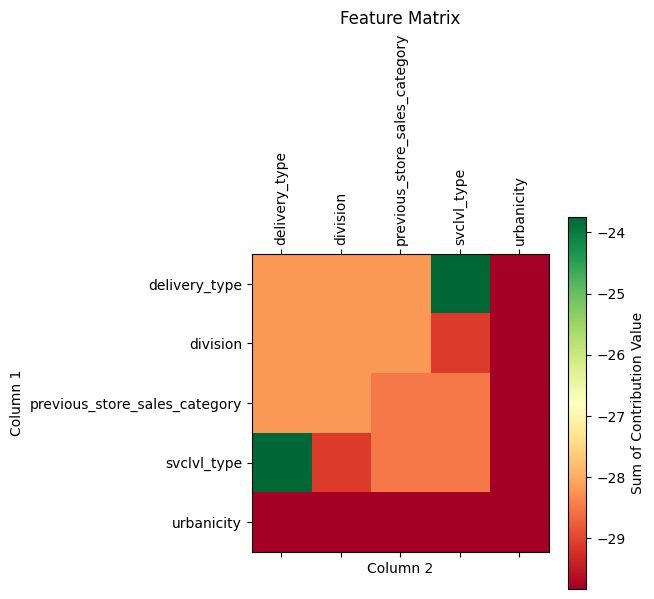

In [ ]:
#Future section to build charts and tables
#
#///////////////////////////////////////////////////////////////////////
# CHARTS and TABLES
#///////////////////////////////////////////////////////////////////////
#
dfGraphs = pd.DataFrame()
dfGraphs = dfFINALOUTPUT.groupby(['COLUMN_1', 'COLUMN_2'])['TOTAL_CONTRIBUTION_60_DAYS'].sum().unstack(fill_value=0)

# plt.imshow(dfFINALOUTPUT.groupby(['COLUMN_1', 'COLUMN_2'])['TOTAL_CONTRIBUTION_60_DAYS'].sum(), cmap ="RdYlBu") 
  
plt.figure(figsize=(8, 6))
plt.matshow(dfGraphs, cmap='RdYlGn')  # You can choose a different colormap if desired
plt.xticks(range(len(dfGraphs.columns)), dfGraphs.columns, rotation=90)
plt.yticks(range(len(dfGraphs.index)), dfGraphs.index)
plt.xlabel('Column 2')
plt.ylabel('Column 1')
plt.title('Feature Matrix')
plt.colorbar(label='Sum of Contribution Value')
plt.show()



INDEX_2                                          A - NO_STORE_TXNS  B - 1-250  \
COLUMN_1                      INDEX_1                                           
delivery_type                 DELIVERY                   43.048391   6.479199   
                              DUG                       -74.038808 -13.657671   
division                      DENVER                     -0.919591  -1.263389   
                              HAGGEN                     -0.134169   0.089795   
                              INTERMOUNTAIN               1.770343   0.326860   
                              JEWEL OSCO                 -3.921456  -4.427000   
                              MID-ATLANTIC               -3.630205  -0.472953   
                              NORCAL                      5.885532   3.032895   
                              PORTLAND                   -4.977809   0.945896   
                              SEATTLE                    -3.234638  -1.663929   
                              SHAWS                      -1.653860  -1.303546   
                              SOCAL                     -10.500445  -3.197871   
                              SOUTHERN                   -3.419411   1.155629   
                              SOUTHWEST                  -6.254706  -0.400858   
previous_store_sales_category A - NO_STORE_TXNS         -31.082886   0.000000   
                              B - 1-250                   0.000000  -7.226717   
                              C - 250-500                 0.000000   0.000000   
                              D - 500-1000                0.000000   0.000000   
                              E - 1000-1500               0.000000   0.000000   
                              F - 1500-3000               0.000000   0.000000   
                              G - 3000-15000              0.000000   0.000000   
                              H - 15000 +                 0.000000   0.000000   
svclvl_type                   EXPRESS                   -12.967456   0.058780   
                              FLASH                      -0.366914  -1.766318   
                              STANDARD                  -17.748516  -5.519179   
urbanicity                    Rural                      -6.141647  -0.405987   
                              Suburban                  -33.133635  -7.908441   
                              Urban                       7.253535   1.368274   

INDEX_2                                          C - 250-500  D - 500-1000  \
COLUMN_1                      INDEX_1                                        
delivery_type                 DELIVERY              3.162588      0.513375   
                              DUG                   0.851417      6.224415   
division                      DENVER                0.816950     -0.151270   
                              HAGGEN                0.135242      0.080916   
                              INTERMOUNTAIN         0.582760      0.816072   
                              JEWEL OSCO           -0.510664      1.582011   
                              MID-ATLANTIC          0.526581      0.027447   
                              NORCAL                1.989118      3.109553   
                              PORTLAND              0.491713      0.888353   
                              SEATTLE               0.615652     -1.902853   
                              SHAWS                -0.316349      0.118433   
                              SOCAL                -1.676598      0.072867   
                              SOUTHERN              1.953185      0.676803   
                              SOUTHWEST            -0.593585      1.419458   
previous_store_sales_category A - NO_STORE_TXNS     0.000000      0.000000   
                              B - 1-250             0.000000      0.000000   
                              C - 250-500           4.010926      0.000000   
                              D - 500-1000          0.000000      6.681675   
         

<Figure size 600x600 with 0 Axes>

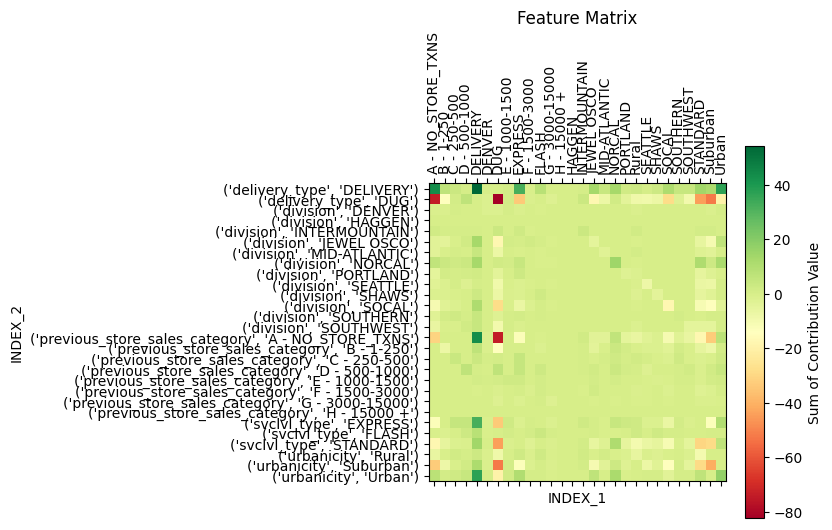

In [ ]:
#Future section to build charts and tables
#
#///////////////////////////////////////////////////////////////////////
# CHARTS and TABLES
#///////////////////////////////////////////////////////////////////////
#
dfGraph_Lvl_2 = pd.DataFrame()
dfGraph_Lvl_2 = dfFINALOUTPUT.groupby(['COLUMN_1','INDEX_1', 'INDEX_2'])['TOTAL_CONTRIBUTION_60_DAYS'].sum().unstack(fill_value=0)
display(dfGraph_Lvl_2)
# plt.imshow(dfFINALOUTPUT.groupby(['COLUMN_1', 'COLUMN_2'])['TOTAL_CONTRIBUTION_60_DAYS'].sum(), cmap ="RdYlBu") 
  
plt.figure(figsize=(5, 5), dpi=120)
plt.matshow(dfGraph_Lvl_2, cmap='RdYlGn')  # You can choose a different colormap if desired
plt.xticks(range(len(dfGraph_Lvl_2.columns)), dfGraph_Lvl_2.columns, rotation=90)
plt.yticks(range(len(dfGraph_Lvl_2.index)), dfGraph_Lvl_2.index)
plt.xlabel('INDEX_1')
plt.ylabel('INDEX_2')
plt.title('Feature Matrix')
plt.colorbar(label='Sum of Contribution Value')
plt.show()


In [47]:
dfFINALOUTPUT[(dfFINALOUTPUT['COLUMN_1'] == 'division') & (dfFINALOUTPUT['COLUMN_2'] != 'division')]

,TOTAL_CONTRIBUTION_30_DAYS,TOTAL_CONTRIBUTION_60_DAYS,FEATURES,NUM_FEATURES,NUM_HH_FIRST_TIMEPERIOD,NUM_HH_LAST_TIMEPERIOD,VARIANCE,RPT_RATE_60_BPS_DIFF,60_DAY_RATE_CONTRIBUTION,60_DAY_MIX_CONTRIBUTION,INDEX,COLUMN_1,INDEX_1,INDEX_2,COLUMN_2
415,10.909242,12.693032,division::delivery_type,2,84276.0,66748,-0.011245,346.468239,16.023745,-3.330713,"(NORCAL, DELIVERY)",division,NORCAL,DELIVERY,delivery_type
411,12.707916,12.666554,division::delivery_type,2,43990.0,43748,0.000302,412.655793,12.508594,0.157960,"(JEWEL OSCO, DELIVERY)",division,JEWEL OSCO,DELIVERY,delivery_type
481,10.958145,11.822789,division::urbanicity,2,79322.0,74603,-0.002422,213.317122,11.026669,0.796120,"(NORCAL, Urban)",division,NORCAL,Urban,urbanicity
446,8.293551,10.898436,division::svclvl_type,2,152371.0,110250,-0.027557,71.494571,5.461526,5.436910,"(NORCAL, STANDARD)",division,NORCAL,STANDARD,svclvl_type
423,9.976308,10.635389,division::delivery_type,2,69879.0,57294,-0.007973,307.477392,12.206318,-1.570929,"(SOCAL, DELIVERY)",division,SOCAL,DELIVERY,delivery_type
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,-11.167393,-13.633067,division::urbanicity,2,104951.0,103116,-0.000150,-190.870809,-13.637285,0.004218,"(SOCAL, Suburban)",division,SOCAL,Suburban,urbanicity
412,-22.823178,-17.324712,division::delivery_type,2,98648.0,120571,0.016244,-174.850911,-14.607406,-2.717306,"(JEWEL OSCO, DUG)",division,JEWEL OSCO,DUG,delivery_type
424,-23.293080,-28.417444,division::delivery_type,2,155863.0,169011,0.010775,-214.320201,-25.098076,-3.319368,"(SOCAL, DUG)",division,SOCAL,DUG,delivery_type
433,NaN,NaN,division::svclvl_type,2,NaN,141,NaN,NaN,NaN,NaN,"(HAGGEN, FLASH)",division,HAGGEN,FLASH,svclvl_type


INDEX_2                 A - NO_STORE_TXNS  B - 1-250  C - 250-500  \
COLUMN_1 INDEX_1                                                    
division DENVER                 -0.919591  -1.263389     0.816950   
         HAGGEN                 -0.134169   0.089795     0.135242   
         INTERMOUNTAIN           1.770343   0.326860     0.582760   
         JEWEL OSCO             -3.921456  -4.427000    -0.510664   
         MID-ATLANTIC           -3.630205  -0.472953     0.526581   
         NORCAL                  5.885532   3.032895     1.989118   
         PORTLAND               -4.977809   0.945896     0.491713   
         SEATTLE                -3.234638  -1.663929     0.615652   
         SHAWS                  -1.653860  -1.303546    -0.316349   
         SOCAL                 -10.500445  -3.197871    -1.676598   
         SOUTHERN               -3.419411   1.155629     1.953185   
         SOUTHWEST              -6.254706  -0.400858    -0.593585   

INDEX_2                 D - 500-1000   DELIVERY        DUG  E - 1000-1500  \
COLUMN_1 INDEX_1                                                            
division DENVER            -0.151270   0.297798  -1.719220       0.402480   
         HAGGEN             0.080916   0.000000  -0.006459      -0.020830   
         INTERMOUNTAIN      0.816072   0.388805   3.046852       0.190653   
         JEWEL OSCO         1.582011  12.666554 -17.324712       1.225924   
         MID-ATLANTIC       0.027447   4.060649  -7.486500       0.013406   
         NORCAL             3.109553  12.693032   1.885899       0.945185   
         PORTLAND           0.888353   1.502877  -4.222388       0.168993   
         SEATTLE           -1.902853   0.658799  -8.810630      -0.632321   
         SHAWS              0.118433   2.702885  -7.176098      -1.158290   
         SOCAL              0.072867  10.635389 -28.417444      -0.352791   
         SOUTHERN           0.676803   4.244269  -2.874310       0.743476   
         SOUTHWEST          1.419458   4.353586  -9.306583       0.787254   

INDEX_2                  EXPRESS  F - 1500-3000     FLASH  G - 3000-15000  \
COLUMN_1 INDEX_1                                                            
division DENVER        -0.841379      -0.159487 -0.610427       -0.134045   
         HAGGEN         0.033820      -0.145329  0.000000       -0.012085   
         INTERMOUNTAIN  2.146962      -0.419243  0.040824        0.164315   
         JEWEL OSCO     0.665027       1.633179  0.404459       -0.230504   
         MID-ATLANTIC  -0.354023       0.097762 -0.471164        0.027670   
         NORCAL         4.227632      -0.103399 -0.547138       -0.303198   
         PORTLAND       2.478404      -0.044856  0.032716       -0.195698   
         SEATTLE       -1.576246      -0.708487  0.174991       -0.627146   
         SHAWS         -1.342134      -0.035583  2.234671       -0.132875   
         SOCAL         -7.147701      -1.495472  0.752913       -0.639047   
         SOUTHERN       1.295375       0.213229  0.492317        0.070699   
         SOUTHWEST     -0.915977       0.055669  0.000000        0.040087   

INDEX_2                 H - 15000 +     Rural   STANDARD   Suburban      Urban  
COLUMN_1 INDEX_1                                                                
division DENVER           -0.013070 -0.879820   0.030384  -0.991083   0.479546  
         HAGGEN            0.000000  0.038107  -0.023088  -0.044566   0.000000  
         INTERMOUNTAIN     0.003897  1.591440   1.247871   1.304852  -0.049013  
         JEWEL OSCO       -0.009648 -0.384577  -5.727644 -10.604369   6.489122  
         MID-ATLANTIC     -0.015559  1.067832  -2.600665  -3.479770   0.165262  
         NORCAL            0.023244 -0.702638  10.898436   2.964258  11.822789  
         PORTLAND          0.003897 -1.305394  -5.230632  -2.508097  -0.256206  
         SEATTLE           0.001891 -1.176907  -6.750576  -7.263030   0.457333  
         SHAWS             0.008858 -2.237503  -5.365750  -2.9792

<Figure size 600x600 with 0 Axes>

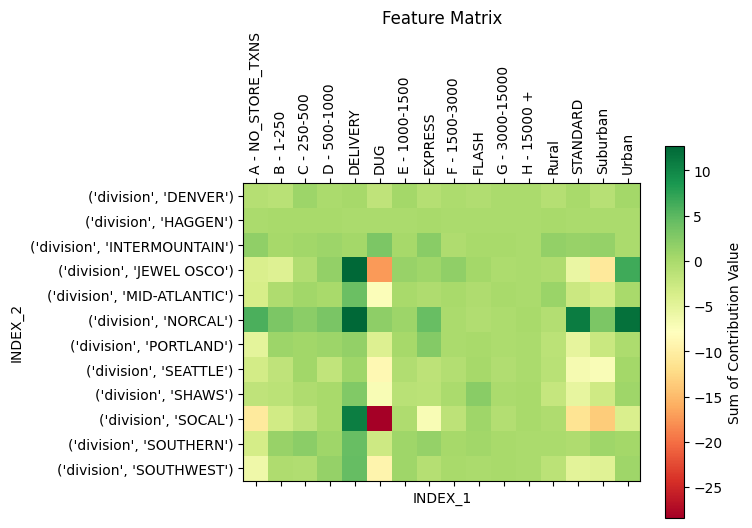

In [48]:
#
#///////////////////////////////////////////////////////////////////////
# DIVISION LEVEL
#///////////////////////////////////////////////////////////////////////
#
dfGraph_Lvl_3 = pd.DataFrame()
dfDIVISION = dfFINALOUTPUT[(dfFINALOUTPUT['COLUMN_1'] == 'division') & (dfFINALOUTPUT['COLUMN_2'] != 'division')]
dfGraph_Lvl_3 = dfDIVISION.groupby(['COLUMN_1','INDEX_1', 'INDEX_2'])['TOTAL_CONTRIBUTION_60_DAYS'].sum().unstack(fill_value=0)
display(dfGraph_Lvl_3)
# plt.imshow(dfFINALOUTPUT.groupby(['COLUMN_1', 'COLUMN_2'])['TOTAL_CONTRIBUTION_60_DAYS'].sum(), cmap ="RdYlBu") 
  
plt.figure(figsize=(5, 5), dpi=120)
plt.matshow(dfGraph_Lvl_3, cmap='RdYlGn')  # You can choose a different colormap if desired
plt.xticks(range(len(dfGraph_Lvl_3.columns)), dfGraph_Lvl_3.columns, rotation=90)
plt.yticks(range(len(dfGraph_Lvl_3.index)), dfGraph_Lvl_3.index)
plt.xlabel('INDEX_1')
plt.ylabel('INDEX_2')
plt.title('Feature Matrix')
plt.colorbar(label='Sum of Contribution Value')
plt.show()
